In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Clean stuff

In [2]:
!rm -rf /kaggle/working/*

# Import libraries and Customize Parameters

In [3]:
# Pip install method (recommended)
%pip install ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 21.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing the required libraries
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
import torch

sns.set_style('darkgrid')

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Check if PyTorch is using the GPU
print("Is CUDA available? ", torch.cuda.is_available())
print("Device name: ", torch.cuda.get_device_name(0))
# Set the device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is on: {device}')

Is CUDA available?  True
Device name:  Tesla P100-PCIE-16GB
Device is on: cuda


# Visualize simple images with annotations

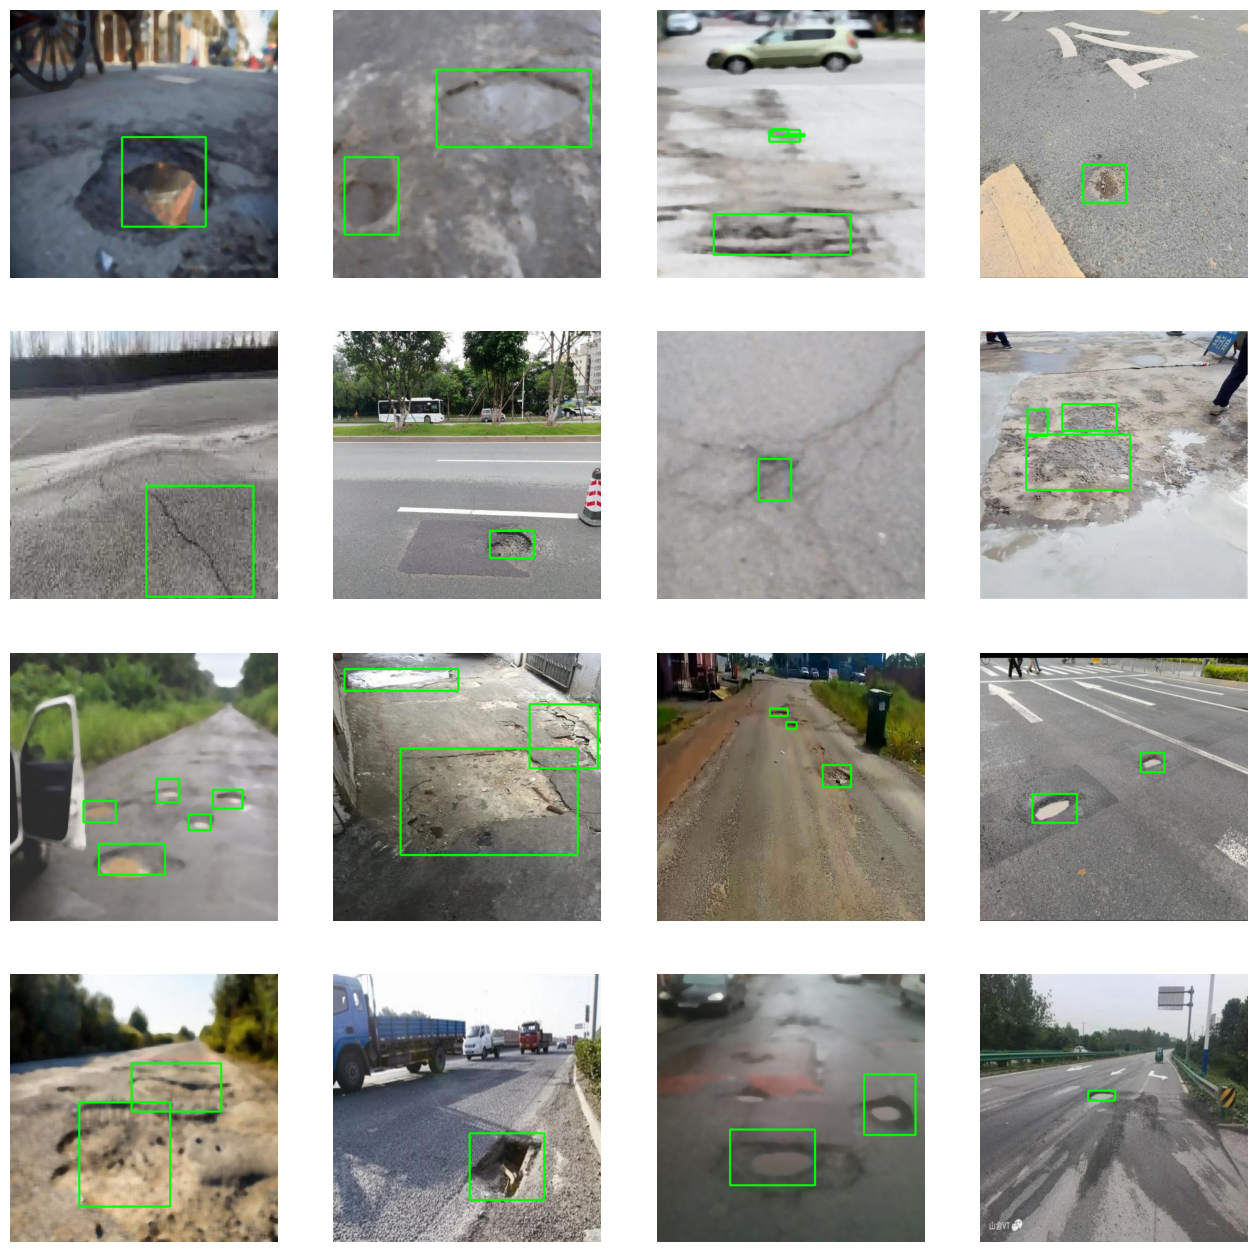

In [6]:
# Define the paths to the images and labels directories
train_images = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/train/images"
train_labels = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/train/labels"

test_images = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images"
test_labels = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images"

val_images = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/valid/images"
val_labels = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/valid/labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

# Show image metadata

In [7]:
# Load an image using OpenCV
image = cv2.imread("/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images/0004_jpg.rf.f92ab952cd8544f887caf35fcccbcd10.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 640x640 and 3 channels.


# Model Training

In [8]:
# Loading a pretrained model
model = YOLO('yolo11n.pt')

# free up GPU memory
torch.cuda.empty_cache()

# Training the model
model.train(data = '/kaggle/input/pothole-reduced-dataset/reduced_dataset/data.yaml',
            epochs = 100,
            imgsz = (height, width, channels),
            seed = 42,
            batch = 8,
            workers = 4,
            optimizer = "Adam")

100%|██████████| 5.35M/5.35M [00:00<00:00, 118MB/s]

Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/pothole-reduced-dataset/reduced_dataset/data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=(640, 640, 3), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=tor

100%|██████████| 755k/755k [00:00<00:00, 24.0MB/s]
2024-11-25 13:50:03,864	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-25 13:50:04,320	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/pothole-reduced-dataset/reduced_dataset/train/labels... 2400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:14<00:00, 169.41it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/pothole-reduced-dataset/reduced_dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/pothole-reduced-dataset/reduced_dataset/valid/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:01<00:00, 170.45it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/pothole-reduced-dataset/reduced_dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.46G      2.138      2.473      2.003         49        640: 100%|██████████| 300/300 [00:43<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.94it/s]


                   all        300        936      0.095      0.106     0.0363     0.0109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.44G      2.169       2.39      2.072         38        640: 100%|██████████| 300/300 [00:40<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.75it/s]


                   all        300        936      0.185      0.204      0.135     0.0497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.44G      2.097      2.252      1.987         46        640: 100%|██████████| 300/300 [00:40<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.83it/s]

                   all        300        936      0.366      0.308      0.264      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.44G      2.029      2.148      1.939         44        640: 100%|██████████| 300/300 [00:40<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.20it/s]


                   all        300        936      0.303      0.129      0.112     0.0448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.44G      1.993      2.107      1.903         37        640: 100%|██████████| 300/300 [00:40<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.77it/s]


                   all        300        936      0.508      0.359      0.366       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.44G      1.926      1.986      1.856         30        640: 100%|██████████| 300/300 [00:40<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.20it/s]


                   all        300        936      0.274      0.386      0.208     0.0815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.44G       1.93      1.982      1.872         39        640: 100%|██████████| 300/300 [00:40<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.21it/s]

                   all        300        936      0.378      0.223      0.195     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.44G      1.905      1.922      1.848         40        640: 100%|██████████| 300/300 [00:40<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.29it/s]

                   all        300        936      0.595      0.418       0.44      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.44G      1.885      1.917      1.818         33        640: 100%|██████████| 300/300 [00:39<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.51it/s]

                   all        300        936      0.584      0.389      0.421       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.44G      1.858      1.877      1.808         27        640: 100%|██████████| 300/300 [00:39<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.50it/s]

                   all        300        936      0.577      0.366      0.411       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.44G      1.869      1.879      1.811         39        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.05it/s]


                   all        300        936      0.549      0.391      0.419      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.46G      1.845      1.832      1.801         18        640: 100%|██████████| 300/300 [00:39<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.80it/s]


                   all        300        936      0.594      0.442      0.481      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.44G      1.839      1.846      1.794         27        640: 100%|██████████| 300/300 [00:39<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.12it/s]

                   all        300        936      0.514      0.455      0.458      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.44G      1.846      1.812      1.781         44        640: 100%|██████████| 300/300 [00:39<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.51it/s]

                   all        300        936        0.5      0.424      0.429      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.44G      1.843      1.821      1.803         48        640: 100%|██████████| 300/300 [00:40<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]

                   all        300        936      0.568      0.436      0.455      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.44G      1.792      1.767      1.754         43        640: 100%|██████████| 300/300 [00:40<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.11it/s]

                   all        300        936      0.636      0.487      0.525      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.46G      1.784      1.737      1.751         43        640: 100%|██████████| 300/300 [00:40<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.20it/s]

                   all        300        936      0.556      0.406      0.442      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.44G      1.824      1.746       1.77         54        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.24it/s]


                   all        300        936      0.606      0.422      0.456      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.44G      1.785      1.714      1.754         38        640: 100%|██████████| 300/300 [00:39<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.32it/s]

                   all        300        936      0.588      0.492      0.539      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.44G      1.799      1.727      1.747         76        640: 100%|██████████| 300/300 [00:39<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.26it/s]

                   all        300        936      0.586      0.466        0.5      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.46G      1.774      1.692      1.725         39        640: 100%|██████████| 300/300 [00:39<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.28it/s]

                   all        300        936      0.553      0.431      0.454      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.46G      1.765      1.666      1.715         27        640: 100%|██████████| 300/300 [00:39<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.59it/s]

                   all        300        936      0.565       0.51      0.514      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.44G      1.747      1.645      1.712         30        640: 100%|██████████| 300/300 [00:39<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]

                   all        300        936      0.613      0.471      0.523      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.44G      1.769      1.671       1.73         52        640: 100%|██████████| 300/300 [00:39<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.14it/s]

                   all        300        936      0.608      0.486      0.525      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.45G      1.762      1.663      1.726         50        640: 100%|██████████| 300/300 [00:39<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.46it/s]

                   all        300        936      0.623      0.501      0.552      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.46G      1.749      1.654      1.726         38        640: 100%|██████████| 300/300 [00:39<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.61it/s]

                   all        300        936      0.645      0.473      0.527      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.44G      1.747      1.641      1.717         29        640: 100%|██████████| 300/300 [00:39<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.69it/s]

                   all        300        936       0.62      0.449      0.476      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.44G      1.731      1.621      1.707         31        640: 100%|██████████| 300/300 [00:39<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.39it/s]

                   all        300        936      0.618      0.503      0.551      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.44G      1.736      1.618      1.713         21        640: 100%|██████████| 300/300 [00:39<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.09it/s]

                   all        300        936      0.669      0.502      0.568      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.43G      1.748      1.622      1.718         33        640: 100%|██████████| 300/300 [00:39<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.56it/s]


                   all        300        936      0.641      0.464      0.514      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.44G      1.732      1.586      1.701         30        640: 100%|██████████| 300/300 [00:39<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.57it/s]

                   all        300        936      0.616      0.529      0.567      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.44G      1.729      1.582      1.701         39        640: 100%|██████████| 300/300 [00:39<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.39it/s]

                   all        300        936      0.584      0.513      0.542      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.44G      1.694      1.553      1.675         49        640: 100%|██████████| 300/300 [00:39<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.88it/s]


                   all        300        936      0.654      0.516      0.579      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.46G      1.713      1.555      1.687         47        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.37it/s]

                   all        300        936       0.64      0.517      0.572      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.44G      1.696      1.546      1.689         48        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.39it/s]

                   all        300        936      0.627       0.51      0.561      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.44G      1.696      1.542      1.685         34        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.64it/s]


                   all        300        936      0.606      0.527      0.556       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.44G      1.706      1.578      1.687         46        640: 100%|██████████| 300/300 [00:39<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.33it/s]

                   all        300        936      0.672      0.506      0.578      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.45G      1.687      1.526      1.684         34        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.44it/s]

                   all        300        936       0.69      0.532      0.597      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.44G       1.69      1.543      1.695         40        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.89it/s]

                   all        300        936      0.647      0.532      0.575      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.44G      1.685      1.552      1.664         66        640: 100%|██████████| 300/300 [00:39<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.51it/s]

                   all        300        936      0.618      0.471      0.512      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.44G      1.667      1.499      1.662         31        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.33it/s]

                   all        300        936      0.605      0.549      0.567      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.45G      1.685      1.511      1.678         43        640: 100%|██████████| 300/300 [00:41<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.88it/s]


                   all        300        936      0.671      0.568      0.609      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.44G      1.675      1.517      1.659         35        640: 100%|██████████| 300/300 [00:40<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.58it/s]

                   all        300        936      0.671      0.537      0.606      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.44G       1.64      1.489      1.642         29        640: 100%|██████████| 300/300 [00:39<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.49it/s]

                   all        300        936      0.684      0.553      0.597      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.44G      1.642      1.474      1.645         32        640: 100%|██████████| 300/300 [00:40<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.52it/s]

                   all        300        936      0.691      0.522      0.599      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.44G      1.635      1.454      1.643         18        640: 100%|██████████| 300/300 [00:39<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.39it/s]


                   all        300        936      0.627      0.569      0.607      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.44G      1.665      1.498      1.666         41        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.37it/s]

                   all        300        936      0.642      0.567      0.603      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.44G      1.637      1.448       1.64         56        640: 100%|██████████| 300/300 [00:40<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.41it/s]

                   all        300        936      0.662      0.554      0.615      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.44G      1.627      1.454      1.635         45        640: 100%|██████████| 300/300 [00:40<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.37it/s]

                   all        300        936      0.677       0.56      0.612      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.46G      1.612      1.425      1.616         38        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.10it/s]

                   all        300        936      0.633      0.572      0.593      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.44G      1.638      1.442      1.633         22        640: 100%|██████████| 300/300 [00:41<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.43it/s]

                   all        300        936      0.615      0.577      0.615      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.44G      1.617      1.423      1.635         43        640: 100%|██████████| 300/300 [00:40<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.13it/s]


                   all        300        936      0.694      0.567      0.627       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.44G      1.599      1.377      1.602         41        640: 100%|██████████| 300/300 [00:40<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.45it/s]

                   all        300        936      0.638      0.599      0.617      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.44G      1.596      1.398       1.61         30        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.78it/s]


                   all        300        936      0.654      0.544      0.595      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.44G      1.608      1.435      1.608         36        640: 100%|██████████| 300/300 [00:39<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.34it/s]

                   all        300        936      0.647      0.585      0.622      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.44G      1.579      1.375      1.598         27        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.67it/s]


                   all        300        936      0.656      0.588      0.628      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.44G      1.587      1.369      1.606         38        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.84it/s]

                   all        300        936      0.716      0.563      0.645      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.44G       1.59      1.378       1.59         20        640: 100%|██████████| 300/300 [00:39<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.69it/s]


                   all        300        936      0.721      0.592      0.645      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.44G      1.574      1.336      1.575         54        640: 100%|██████████| 300/300 [00:39<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]

                   all        300        936      0.697      0.588      0.654      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.44G      1.582      1.363      1.588         35        640: 100%|██████████| 300/300 [00:40<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.52it/s]

                   all        300        936       0.69      0.623      0.663      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.44G      1.564      1.331      1.579         37        640: 100%|██████████| 300/300 [00:40<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.69it/s]

                   all        300        936      0.721      0.574      0.656      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.44G      1.558      1.344      1.572         22        640: 100%|██████████| 300/300 [00:39<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.44it/s]

                   all        300        936      0.743      0.613       0.67      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.44G      1.571       1.33      1.584         53        640: 100%|██████████| 300/300 [00:40<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.32it/s]

                   all        300        936      0.717      0.561      0.639      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.44G      1.553       1.35      1.573         48        640: 100%|██████████| 300/300 [00:39<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.09it/s]


                   all        300        936      0.711      0.615      0.664      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.44G      1.558      1.332      1.578         31        640: 100%|██████████| 300/300 [00:39<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.57it/s]

                   all        300        936      0.677      0.618       0.65      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.44G      1.533      1.328       1.56         41        640: 100%|██████████| 300/300 [00:39<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.36it/s]

                   all        300        936      0.735      0.609      0.674      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.44G       1.53      1.289      1.553         57        640: 100%|██████████| 300/300 [00:39<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]

                   all        300        936      0.696      0.607      0.653      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.44G      1.525      1.272      1.553         32        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.61it/s]

                   all        300        936      0.735      0.631      0.694      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.46G      1.523      1.304      1.558         37        640: 100%|██████████| 300/300 [00:40<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.57it/s]

                   all        300        936      0.765      0.583      0.667      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.44G      1.532      1.294      1.555         47        640: 100%|██████████| 300/300 [00:40<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.32it/s]

                   all        300        936      0.713      0.616      0.694      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.44G      1.514      1.274      1.547         23        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.36it/s]

                   all        300        936      0.743      0.619      0.685      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.44G       1.51      1.282      1.536         44        640: 100%|██████████| 300/300 [00:40<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.07it/s]

                   all        300        936      0.749      0.618      0.694      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.44G      1.521      1.262      1.545         34        640: 100%|██████████| 300/300 [00:40<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]

                   all        300        936      0.733      0.627      0.691      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.44G      1.501      1.253      1.548         37        640: 100%|██████████| 300/300 [00:40<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.55it/s]

                   all        300        936      0.776      0.624      0.702      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.44G      1.503      1.253      1.527         37        640: 100%|██████████| 300/300 [00:40<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.52it/s]


                   all        300        936      0.728      0.649      0.691      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.44G      1.462      1.214      1.506         52        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.48it/s]

                   all        300        936      0.751      0.646      0.707      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.46G       1.48      1.239      1.511         38        640: 100%|██████████| 300/300 [00:39<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.57it/s]

                   all        300        936      0.737      0.641        0.7      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.44G      1.457      1.211      1.503         22        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.87it/s]

                   all        300        936      0.762       0.65      0.706      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.44G      1.477      1.234      1.514         26        640: 100%|██████████| 300/300 [00:40<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.01it/s]

                   all        300        936      0.788      0.613      0.706      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.44G      1.465      1.226      1.506         44        640: 100%|██████████| 300/300 [00:39<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.80it/s]

                   all        300        936        0.7      0.652      0.703      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.46G       1.47      1.223      1.513         48        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.17it/s]

                   all        300        936      0.754      0.651      0.719      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.44G      1.441      1.171      1.481         53        640: 100%|██████████| 300/300 [00:40<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.15it/s]

                   all        300        936      0.784      0.634       0.72      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.44G      1.436      1.169       1.48         35        640: 100%|██████████| 300/300 [00:40<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.20it/s]

                   all        300        936      0.763      0.661      0.726      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.44G      1.438      1.163      1.485         39        640: 100%|██████████| 300/300 [00:40<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.58it/s]

                   all        300        936      0.803      0.614      0.714      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.46G      1.422      1.172      1.476         48        640: 100%|██████████| 300/300 [00:40<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.66it/s]

                   all        300        936       0.74      0.656      0.727      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.44G      1.419      1.171      1.476         16        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.23it/s]

                   all        300        936       0.77       0.65      0.728       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.44G      1.437      1.158      1.473         54        640: 100%|██████████| 300/300 [00:40<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]

                   all        300        936      0.777      0.649      0.725      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.44G      1.422      1.138      1.457         35        640: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.59it/s]

                   all        300        936      0.771      0.669      0.736      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.44G        1.4       1.15      1.465         55        640: 100%|██████████| 300/300 [00:40<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.62it/s]

                   all        300        936      0.792      0.645      0.734       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.44G      1.386      1.115      1.452         35        640: 100%|██████████| 300/300 [00:39<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.46it/s]

                   all        300        936      0.795      0.666      0.739      0.436


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.44G      1.389      1.061      1.471         19        640: 100%|██████████| 300/300 [00:40<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.38it/s]


                   all        300        936      0.816      0.653      0.739      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.44G      1.371      1.008      1.462         22        640: 100%|██████████| 300/300 [00:39<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.14it/s]

                   all        300        936      0.801      0.676      0.747      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.44G      1.343     0.9896      1.442         23        640: 100%|██████████| 300/300 [00:39<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.84it/s]

                   all        300        936      0.814      0.676       0.75      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.44G      1.332      0.983      1.436         28        640: 100%|██████████| 300/300 [00:39<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]

                   all        300        936      0.799      0.683      0.753      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.44G      1.322     0.9685      1.424         17        640: 100%|██████████| 300/300 [00:39<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.31it/s]

                   all        300        936      0.828      0.683      0.763      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.44G      1.313     0.9684      1.419         32        640: 100%|██████████| 300/300 [00:39<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.47it/s]

                   all        300        936      0.832      0.688       0.77      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.44G       1.29     0.9537      1.406         28        640: 100%|██████████| 300/300 [00:39<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.35it/s]

                   all        300        936      0.826      0.701       0.77       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.44G      1.296     0.9403      1.401         22        640: 100%|██████████| 300/300 [00:39<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.34it/s]


                   all        300        936      0.826      0.693      0.769      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.44G      1.286     0.9334      1.392         26        640: 100%|██████████| 300/300 [00:39<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.94it/s]

                   all        300        936      0.825      0.694      0.772      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.44G      1.268     0.9152      1.388         35        640: 100%|██████████| 300/300 [00:39<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.74it/s]

                   all        300        936      0.843      0.702      0.773      0.469



100 epochs completed in 1.184 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.01it/s]


                   all        300        936      0.842      0.703      0.772      0.468
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b3a4956c9d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Model Performance

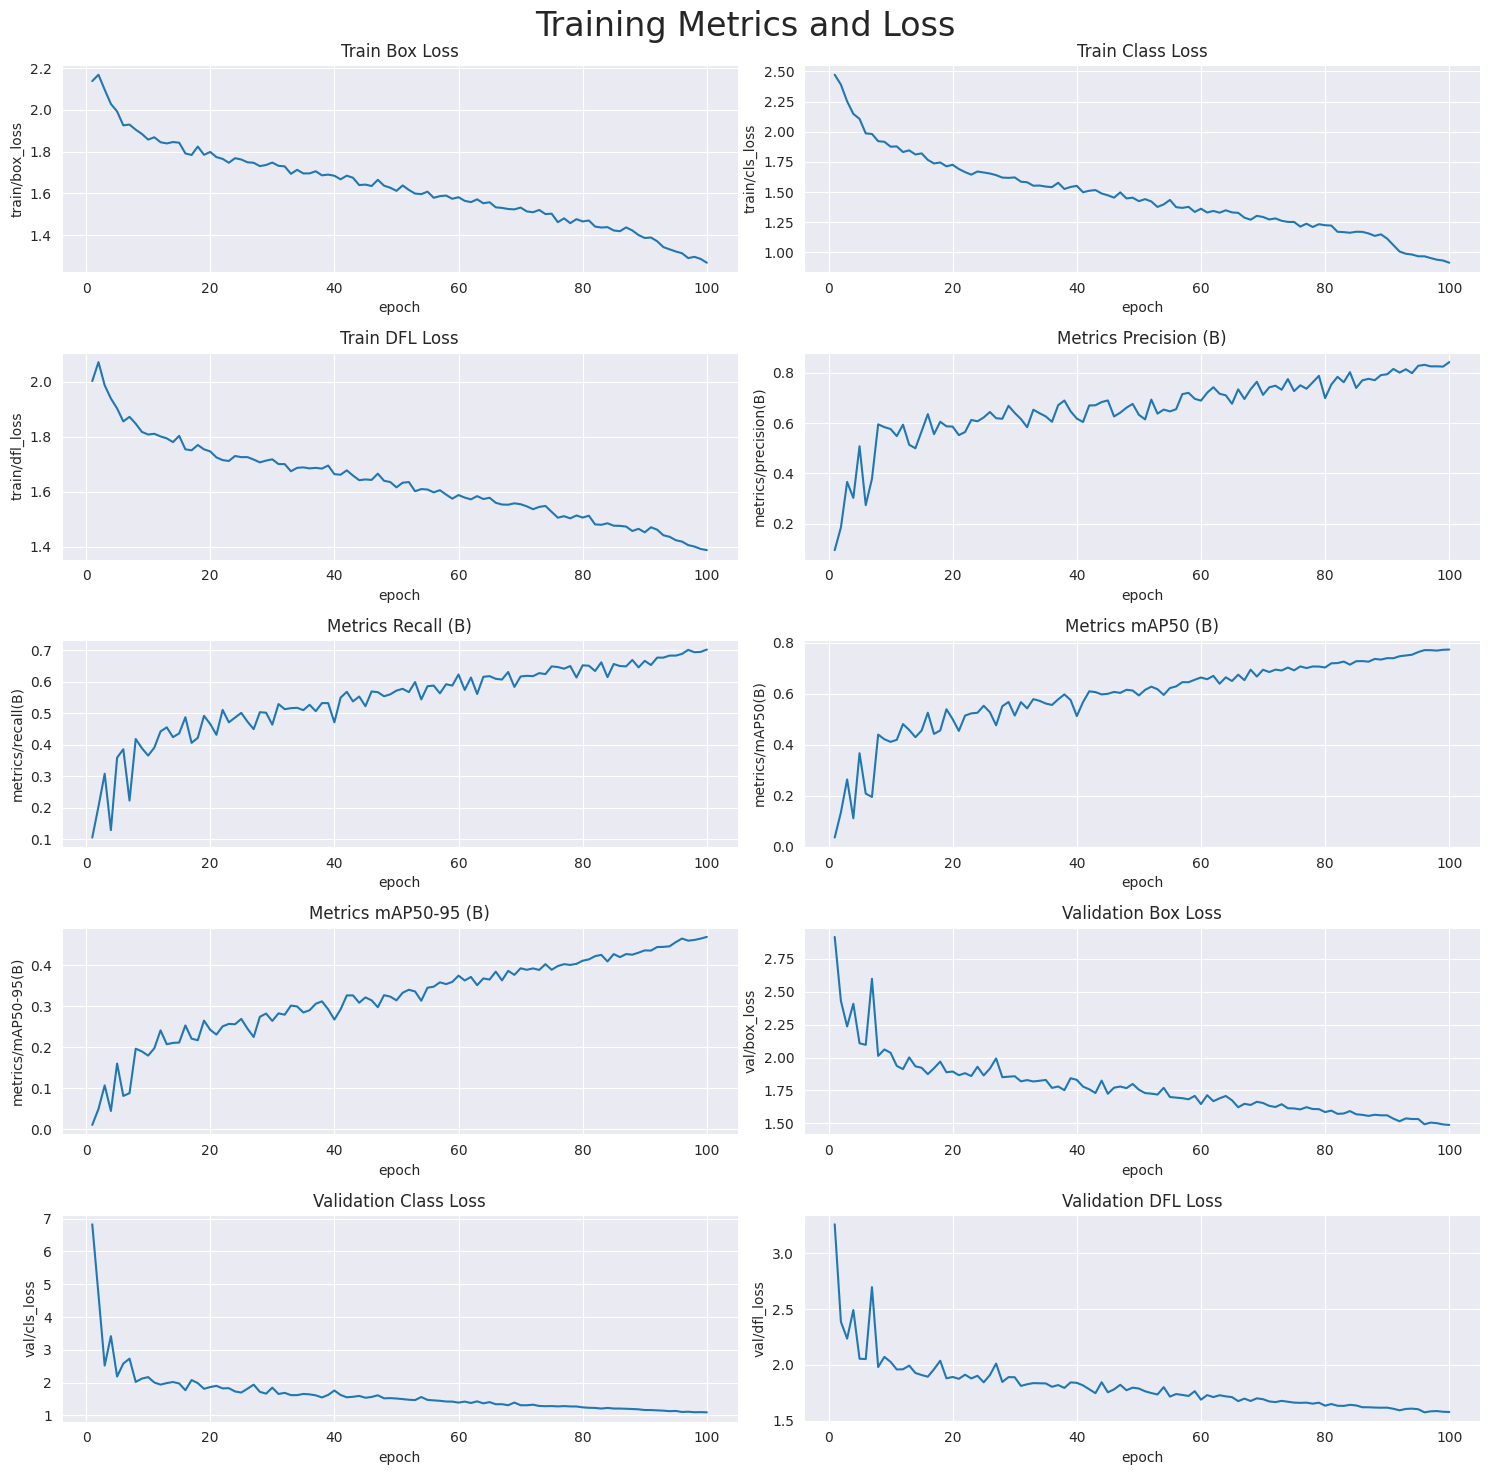

In [9]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Model Evaluation

In [10]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/pothole-reduced-dataset/reduced_dataset/test/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:01<00:00, 157.06it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/pothole-reduced-dataset/reduced_dataset/test is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.67it/s]


                   all        300        844      0.853      0.715       0.82      0.544
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val


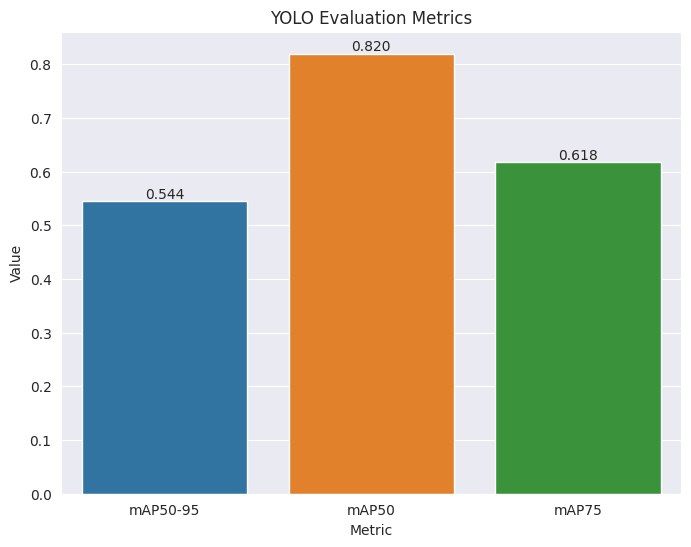

In [11]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
# Show the plot
plt.show()


## Confusion Matrix

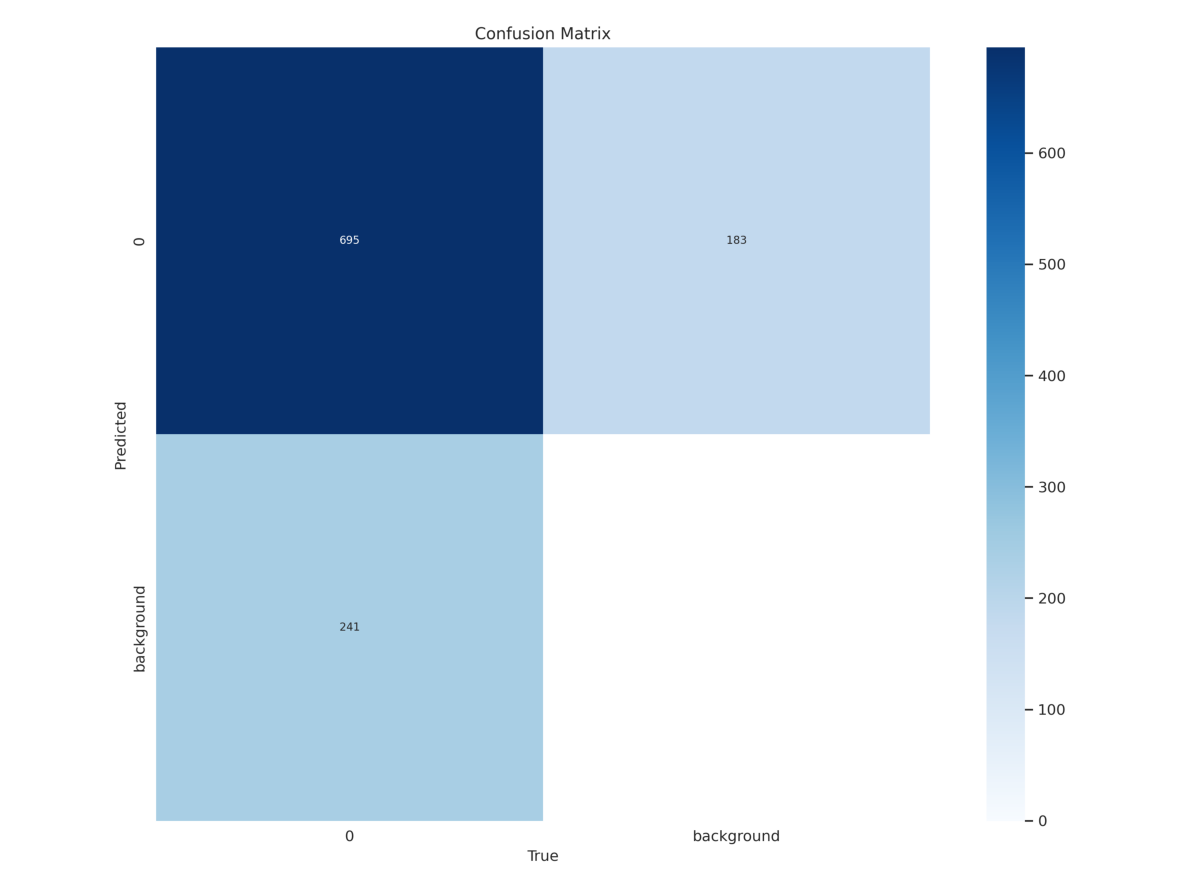

In [12]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# Making Predictions on Test Images

In [13]:
# Function to perform ship detections
def pothole_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 640x640 1 0, 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 0s, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 0s, 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 0s, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 0s, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 0s, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 0s, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 0s, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 0s, 7.5ms
Speed: 2.0ms prep

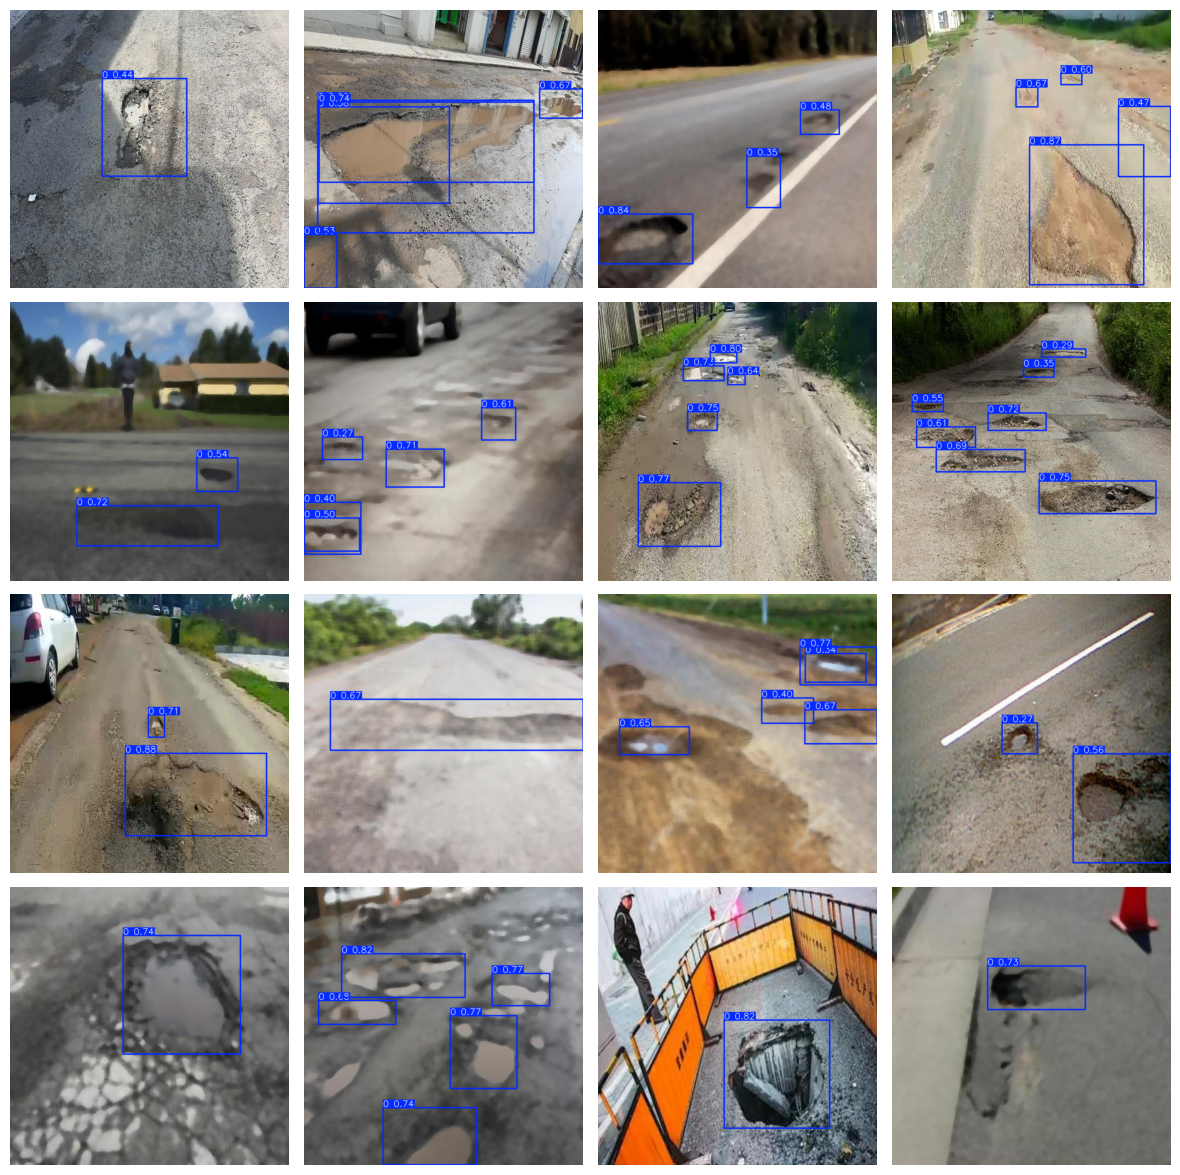

In [14]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = pothole_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Download train results and model

In [15]:
# zip the test results folder
!zip -r yolo_training_results.zip /kaggle/working/runs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/val/ (stored 0%)
  adding: kaggle/working/runs/detect/val/F1_curve.png (deflated 19%)
  adding: kaggle/working/runs/detect/val/val_batch1_pred.jpg (deflated 9%)
  adding: kaggle/working/runs/detect/val/P_curve.png (deflated 21%)
  adding: kaggle/working/runs/detect/val/confusion_matrix_normalized.png (deflated 39%)
  adding: kaggle/working/runs/detect/val/R_curve.png (deflated 19%)
  adding: kaggle/working/runs/detect/val/val_batch2_pred.jpg (deflated 6%)
  adding: kaggle/working/runs/detect/val/PR_curve.png (deflated 17%)
  adding: kaggle/working/runs/detect/val/val_batch0_labels.jpg (deflated 8%)
  adding: kaggle/working/runs/detect/val/confusion_matrix.png (deflated 39%)
  adding: kaggle/working/runs/detect/val/val_batch2_labels.jpg (deflated 6%)
  adding: kaggle/working/runs/detect/val/val_batch1_labels.jpg (deflated 9%)
  adding: kaggle/working/runs/det

In [16]:
!mkdir /kaggle/output/
!mv yolo_training_results.zip /kaggle/output/